# Инфраструктура Python. 3D графика

Описывается библиотека `PyOpenGL` (обертка над отраслевым стандартом OpenGL, в том числе стандартизированным для веба в WebGL). Взаимодействие с оконной подсистемой обеспечивает `PyQt5.QtOpenGL`. В примерах используется OpenGL 3.3 Core 5-летней давности.

```
pip install PyOpenGL
```

Программирование 3D графики заключается в следующих шагах:
    
* Программа создает окно и сообщает системе о том, что хочет воспользоваться 3D;
* настраивает игровой цикл (синхронный или организованный событиями таймера), в котором происходит все остальное;
* читает события мыши и клавиатуры, возможно, сети;
* обновляет согласно действиям пользователя состояние мира: положение и свойства объектов, камеры, размер окна;

на каждом кадре (обычно 30 или 60 раз в секунду) выполняет графическую часть,

* генерирует несколько буферов для передачи видеокарте, которые описывают вершины, индексы вершин полигонов (как правило треугольников), текстурные координаты вершин, нормали;
* настраивает шейдеры (программы, исполняющиеся на видеокарте), мировую матрицу и другие параметры рендеринга;
* передает данные на рендеринг (draw call, эти шаги могут выполняться за один кадр несколько раз);

затем работает видеокарта

* видеокарта рисует полигоны, сперва транслируя их 3D-координаты в экранные с помощью мировой, видовой, проекционной матриц (этот шаг настраивается вершинным шейдером);
* видеокарта отрисовывает полигоны (обычно) в пиксельный буфер и буфер глубины так, чтобы рисовался только ближайший к камере пиксель полигона (этот шаг настраивается пиксельным шейдером);
* видеокарта передает сформированный кадр монитору, в идеале непосредственно перед тем, как монитор начнет очередную отрисовку (обычно это происходит с частотой 60 Hz) — тогда задержка между действиями пользователя и изменением картинки минимальна и причиняет ему меньше душевных терзаний.

<img src="https://games.mail.ru/pic/pc/gallery/f4/7e/aee1d6fe.jpeg">

In [1]:
%pylab inline
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtWebKit import *

from PyQt5.QtOpenGL import *
from OpenGL.GL import *
from OpenGL.GL.shaders import *
from OpenGL.GLU import *

import math, sys, time

Populating the interactive namespace from numpy and matplotlib


In [2]:
import PIL.Image
from io import BytesIO

pixmap = None
def run_qt_and_screenshot(WindowClass, method='pyqt5', fullscreen=False):
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication([])

    def closeEvent(self, event):
        global pixmap
        rect = self.frameGeometry()
        dw = QDesktopWidget()
        desktop_id = dw.screen(dw.screenNumber(self)).winId()
        if method == 'pyside':
            pixmap = QPixmap.grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        elif method == 'pyqt5':
            pixmap = QApplication.primaryScreen().grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        event.accept()
        
    WindowClass.closeEvent = closeEvent
    window = WindowClass()
    if fullscreen:
        window.showFullScreen() # .showNormal для переключения
    else:
        window.show()

    if method == 'pyside':
        try:
            from IPython.lib.guisupport import start_event_loop_qt4
            start_event_loop_qt4(app)
        except ImportError:
            app.exec_()
    elif method == 'pyqt5':
        app.exec_()

    io = QBuffer()
    pixmap.save(io, 'PNG')
    return PIL.Image.open(BytesIO(io.data().data()))

## Отрисовка из вершинного буфера

Этот вершинный буфер описывает квадрат из двух треугольников. Координаты по z подобраны так, чтобы местами вылазить за z-границы кубической области видимости. С простейшими шейдерами примера куб 3D координат `x=[-1,1], y=[-1,1], z=[-1,1]` (y снизу вверх, z от глаз вглубь) ортогонально (без перспективного искажения) отображается в экранные координаты `x=[-1,1], y=[-1,1]`, которые отрисовываются в область окна, установленную `glViewport`.

In [8]:
vertex_buffer = array([
    (-1.0, -1.0, -1.1),
    (1.0, -1.0, 1.1),
    (-1.0, 1.0, 1.1),
    (-1.0, 1.0, 1.1),
    (1.0, -1.0, 1.1),
    (1.0, 1.0, 0.0),
], dtype=float32) * 0.99

**VAO** это способ объединить несколько буферов (обязательно — координаты вершин, необязательно — остальное, текстурные координаты, вектора нормалей, цвета). Функции
* `glGen*` создают объект (VAO или VBO),
* `glBind*` устанавливают текущим,
* `glBufferData` указывает данные для VBO,
* `glVertexAttribPointer` указывает VAO текущий VBO в качестве источника для переменной `layout (location = #) in ...`

In [9]:
def make_vao(*attribs, **kwargs):
    VAO = glGenVertexArrays(1)
    glBindVertexArray(VAO)

    for i, attrib in enumerate(attribs):
        VBO = glGenBuffers(1)
        glBindBuffer(GL_ARRAY_BUFFER, VBO)
        glBufferData(GL_ARRAY_BUFFER, attrib.nbytes, attrib, GL_STATIC_DRAW)
        typ = {'float32': GL_FLOAT}[attrib.dtype.name]
        glVertexAttribPointer(i, attrib.shape[1], typ, GL_FALSE, attrib.shape[1] * attrib.itemsize, None)
        glEnableVertexAttribArray(i)
        glBindBuffer(GL_ARRAY_BUFFER, 0)
        
    if 'index_buffer' in kwargs and not kwargs['index_buffer'] is None:
        IBO = glGenBuffers(1)
        glBindBuffer(GL_ELEMENT_ARRAY_BUFFER, IBO)
        glBufferData(GL_ELEMENT_ARRAY_BUFFER, index_buffer.nbytes, index_buffer, GL_STATIC_DRAW)
        #typ = {'uint32': GL_UNSIGNED_INT}[index_buffer.dtype.name]

    glBindVertexArray(0)
    return VAO

**Шейдеры** это программы, которые в OpenGL пишутся на си-подобном языке GLSL (OpenGL Shading Language) и исполняются для каждой вершины и каждого пикселя, прошедшего depth test.

На вход шейдер принимает атрибуты вершины (например, положение в 3D, `aPos`) и переменные, установленные OpenGL (например, оконные координаты `gl_FragCoord` для пиксельного шейдера) или пользователем (например, `uniform float time;` в шейдере, `glUniform1f((glGetUniformLocation(program, 'time'), current_time)` в коде).

На выход шейдер отдает переменные, которые интересуют следующий шаг в графическом конвейере: например, `gl_Position` (основное возвращаемое значение вершинным шейдером) или то, что раньше называлось `gl_FragColor` (основное возвращаемое значение пиксельным шейдером), а теперь берется из первой `out`-переменной пиксельного шейдера.

Передаваемые между вершинным и пиксельным шейдером пользовательские переменные сопровождаются атрибутом `out` в вершинном и интерполируются между вершинами полигона для каждого пикселя прежде, чем попасть в `in`-переменную с тем же именем в пиксельном. Интерполяцию можно отключить явным указанием атрибута `flat`, тогда для каждого полигона используется значение у provoking vertex (по умолчанию последнего).

Пиксельный шейдер может (например, для прозрачности) вообще отказаться рисовать пиксель инструкцией `discard;`.

In [10]:
vertex_shader_code = '''
#version 330 core
layout (location = 0) in vec3 aPosition;

void main(void) {
    gl_Position = vec4(aPosition, 1.0);
}
'''

In [11]:
fragment_shader_code = '''
#version 330 core

out vec4 FragColor;

void main(void) {
    FragColor = vec4(1.0, 0.0, 0.0, 1.0);
}
'''

Грязную работу инициализации OpenGL (`initializeGL`), обработки ресайза окна (`resizeGL`) и подготовки к отрисовке (`paintGL`) берет на себя `PyQt5.QtOpenGL.QGLWidget`.

Компиляция и использование шейдеров достаточно многословны, вместо набора `glCreateShader+glShaderSource+glCompileShader` и `glCreateProgram+glAttachShader+glLinkProgram+glUseProgram` с проверкой ошибок `glGetShaderInfoLog` можно использовать хелперы `OpenGL.GL.shaders.compileShader` и `OpenGL.GL.shaders.compileProgram`.

3.3.0 - Build 21.20.16.4565


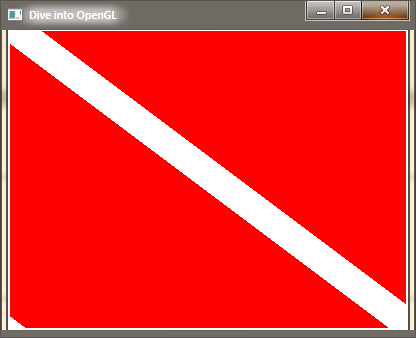

In [12]:
class GLWidget(QGLWidget):
    def __init__(self, parent=None):
        fmt = QGLFormat()
        fmt.setVersion(3, 3)
        fmt.setProfile(QGLFormat.CoreProfile)
        super(GLWidget, self).__init__(fmt, parent)

        self.setWindowTitle('Dive into OpenGL')
        self.resize(400, 300)

    def initializeGL(self):
        # Для полноты картины, используемая версия OpenGL и графического драйвера
        print glGetString(GL_VERSION); sys.stdout.flush()
        
        self.program = compileProgram(
            compileShader(vertex_shader_code, GL_VERTEX_SHADER),
            compileShader(fragment_shader_code, GL_FRAGMENT_SHADER),
        )
        glUseProgram(self.program)
        
        self.vao = make_vao(vertex_buffer)

    def resizeGL(self, width, height):
        # Область окна, куда происходит отрисовка
        glViewport(0, 0, width, height)

    def paintGL(self):
        # Экран очищается белым цветом
        glClearColor(1.0, 1.0, 1.0, 1.0)
        glClear(GL_COLOR_BUFFER_BIT)

        # Устанавливаем текущий VAO и отрисовываем треугольники из него
        glBindVertexArray(self.vao)
        glDrawArrays(GL_TRIANGLES, 0, len(vertex_buffer))
        glBindVertexArray(0)

run_qt_and_screenshot(GLWidget)

## Координаты и камера

Координаты вершин транслируются такой цепочкой:

1. Из координат вершин в модели в мировые координаты мировой матрицей $M_{world}$;
2. Из мировых координат в координаты камеры (в которых камера в (0,0,0), смотрит вдоль (0,0,1), вверх направлен вектор (0,1,0)) видовой матрицей $M_{view}$;
3. Из координат камеры в экранные координаты (координаты пикселя на экране x=[-1,1], y=[-1,1] плюс глубина z) матрицей проекции $M_{proj}$.

Итого, $v' = M_{proj} \cdot M_{view} \cdot M_{world} \cdot v$.

Ранние версии OpenGL предоставляли функции типа `glMatrixMode`, `glLoadIdentity`, `glOrtho`, `gluPerspective`, `gluLookAt`, `glTranslated`, `glRotated` для оперирования со стеком матриц в стейт-машине OpenGL, но сейчас рекомендуется создавать матрицы и передавать их в шейдеры самостоятельно. Это упрощает библиотека `PyGLM`.

```
pip install PyGLM
```

Матрицы строятся из таких примитивов:

* Перенос
$$
\begin{bmatrix}
1 & 0 & 0 & X \\
0 & 1 & 0 & Y \\
0 & 0 & 1 & Z \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
x + X \\
y + Y \\
z + Z \\
1
\end{bmatrix}
$$
* Масштабирование
$$
\begin{bmatrix}
S_x & 0 & 0 & 0 \\
0 & S_y & 0 & 0 \\
0 & 0 & S_z & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
S_x x \\
S_y y \\
S_z z \\
1
\end{bmatrix}
$$
* Вращение (например, вокруг оси Ox)
$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos \theta & -\sin \theta & 0 \\
0 & \sin \theta & \cos \theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
x \\
y \cos \theta - z \sin \theta \\
y \sin \theta + z \cos \theta \\
1
\end{bmatrix}
$$

todo gl_NormalMatrix = transpose(inverse(gl_ModelViewMatrix))

In [13]:
import glm

In [6]:
glm.mat4(1.0)

tmat4x4
[            1 |            0 |            0 |            0 ]
[            0 |            1 |            0 |            0 ]
[            0 |            0 |            1 |            0 ]
[            0 |            0 |            0 |            1 ]

In [7]:
glm.translate(glm.mat4(1.0), glm.vec3(10.0, 0.0, 0.0))

tmat4x4
[            1 |            0 |            0 |            0 ]
[            0 |            1 |            0 |            0 ]
[            0 |            0 |            1 |            0 ]
[           10 |            0 |            0 |            1 ]

Сюрприз, `glm.radians(90.0)` это не 90 радианов, а 90 градусов перевести в радианы.

In [8]:
M = glm.mat4(1.0)
glm.rotate(M, glm.radians(90.0), glm.vec3(0.0, 0.0, 1.0))

tmat4x4
[ 6.12303e-017 |            1 |            0 |            0 ]
[           -1 | 6.12303e-017 |            0 |            0 ]
[            0 |            0 |            1 |            0 ]
[            0 |            0 |            0 |            1 ]

Вращение удобнее задавать (и интерполировать) кватернионами, например, поворот на $\theta$ вокруг оси $(v_x, v_y, v_z)$:

$[w, x, y, z] = [\cos{\frac{\theta}{2}}, v_x \sin{\frac{\theta}{2}}, v_y \sin{\frac{\theta}{2}}, v_z \sin{\frac{\theta}{2}}]$
действие на вектор $v$ равно $q v q^{-1}$, где $v$ — кватернион с нулевой действительной частью.
$[w,x,y,z]^{-1} = \frac{ [w,-x,-y,-z] }{ w^2+x^2+y^2+z^2 }$

In [36]:
q_id = glm.quat(1.0, 0.0, 0.0, 0.0)
q = glm.rotate(q_id, glm.radians(90.0), glm.vec3(0.0, 0.0, 1.0))
print q
print q.w
print q.x, q.y, q.z

tquat(            0,            0,     0.707107,     0.707107 )
0.707106781187
0.0 0.0 0.707106781187


In [38]:
print q_id.w, q_id.x, q_id.y, q_id.z
print q_id

1.0 0.0 0.0 0.0
tquat(            0,            0,            0,            1 )


In [42]:
u = q * q
print u.w, u.x, u.y, u.z

2.22044604925e-16 0.0 0.0 1.0


In [43]:
u = q * q * q
print u.w, u.x, u.y, u.z

-0.707106781187 0.0 0.0 0.707106781187


In [44]:
u = q * q * q * q
print u.w, u.x, u.y, u.z

-1.0 0.0 0.0 2.77555756156e-16


In [45]:
u = q * q * q * q * q
print u.w, u.x, u.y, u.z

-0.707106781187 0.0 0.0 -0.707106781187


In [46]:
u = q * q * q * q * q * q
print u.w, u.x, u.y, u.z

-4.4408920985e-16 0.0 0.0 -1.0


In [33]:
glm.lerp(q, q*q, 0.3)

tquat(            0,            0,     0.794975,     0.494975 )

In [34]:
glm.rotate(glm.quat(0.0, 0.0, 0.0, 1.0), glm.radians(90.0 * 0.3 + 180.0 * 0.7), glm.vec3(0.0, 0.0, 1.0))

tquat(            0,            0,     0.233445,     -0.97237 )

In [60]:
M = glm.mat4(1.0)
M = glm.translate(M, glm.vec3(0.0, 0.0, -10.0))
M = glm.rotate(M, 15.0, glm.vec3(1.0, 0.0, 0.0))
M = glm.rotate(M, 15.0, glm.vec3(0.0, 1.0, 0.0))
M = glm.rotate(M, 15.0, glm.vec3(0.0, 0.0, 1.0))
M

tmat4x4
[     0.577126 |    -0.815268 |    0.0475764 |            0 ]
[     0.494016 |     0.302136 |    -0.815268 |            0 ]
[     0.650288 |     0.494016 |     0.577126 |            0 ]
[            0 |            0 |          -10 |            1 ]

In [62]:
glm.mat4_cast()

TypeError: 'tmat4x4Iter' object is not iterable

## События ввода

Класс-посредник `ModelViewerWidget` обрабатывает вращение объекта мышкой, удаление-приближение колесом, передают получившиеся матрицы в uniform-матрицы `M_world`, `M_view`, `M_proj`, обеспечивает переключение к wireframe кнопкой W.

Пиксели, которые дальше от глаз, чем уже нарисованные, не рисуются благодаря буферу глубины, который, как и буфер цвета, надо очищать в каждом кадре.

In [14]:
class ModelViewerWidget(QGLWidget):
    def __init__(self, parent=None):
        fmt = QGLFormat()
        fmt.setVersion(3, 3)
        fmt.setProfile(QGLFormat.CoreProfile)
        super(ModelViewerWidget, self).__init__(fmt, parent)

        # Чтобы Qt передавал события клавиатуры
        self.setFocusPolicy(Qt.StrongFocus)

        self.lastPos = None
        self.rotation = array([0, 0, 0], dtype=float)
        self.x = 0.0
        self.y = 0.0
        self.distance = 5.0
        self.distance_speed = 0.5
        self.distance_min = 1.0
        self.wireframe = False
        self.projection = 'perspective'
        self.fov = 90.0
        self.z_near = 1e-3
        self.z_far = 1000.0
        self.clear_color = [0.3, 0.0, 0.3, 1.0]
        
        self.M_world = glm.mat4(1.0)
        self.M_view = glm.mat4(1.0)
        self.M_proj = glm.mat4(1.0)

    def initializeGL(self):
        glEnable(GL_DEPTH_TEST)
        glClearColor(*self.clear_color)
        
        # Каждые 16 мс дергаем перерисовку
        self.timer = QTimer()
        self.timer.timeout.connect(self.updateGL)
        self.timer.start(16)

    def resizeGL(self, width, height):
        glViewport(0, 0, width, height)
        # Настройка матрицы проекции с сохранением масштабов по осям
        aspect = float(width) / height
        if self.projection == 'perspective':
            self.M_proj = glm.perspective(self.fov, aspect, self.z_near, self.z_far)
        elif self.projection == 'ortho':
            self.M_proj = glm.ortho(-aspect, aspect, -1, 1, self.z_near, self.z_far)

    def paintGL(self):
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

        glPolygonMode(GL_FRONT_AND_BACK, GL_LINE if self.wireframe else GL_FILL)

        # Вращение объекта и отдаление от него
        M = glm.mat4(1.0)
        M = glm.translate(M, glm.vec3(self.x, self.y, -self.distance))
        M = glm.rotate(M, glm.radians(self.rotation[0]), glm.vec3(1.0, 0.0, 0.0))
        M = glm.rotate(M, glm.radians(self.rotation[1]), glm.vec3(0.0, 1.0, 0.0))
        M = glm.rotate(M, glm.radians(self.rotation[2]), glm.vec3(0.0, 0.0, 1.0))
        self.M_world = M
        
        glUniformMatrix4fv(glGetUniformLocation(self.program, 'M_world'), 1, GL_FALSE, glm.value_ptr(self.M_world))
        glUniformMatrix4fv(glGetUniformLocation(self.program, 'M_view'), 1, GL_FALSE, glm.value_ptr(self.M_view))
        glUniformMatrix4fv(glGetUniformLocation(self.program, 'M_proj'), 1, GL_FALSE, glm.value_ptr(self.M_proj))

    def setRotation(self, rotation):
        rotation = (rotation % 360.0 + 360) % 360
        if any(rotation != self.rotation):
            self.rotation = rotation
            self.updateGL()

    def keyPressEvent(self, event):
        if event.key() == Qt.Key_W:
            self.wireframe = not self.wireframe
            self.updateGL()

    def mousePressEvent(self, event):
        self.lastPos = QPoint(event.pos())

    def mouseMoveEvent(self, event):
        dx = event.x() - self.lastPos.x()
        dy = event.y() - self.lastPos.y()
        self.lastPos = QPoint(event.pos())
        if event.buttons() & Qt.LeftButton:
            self.setRotation(self.rotation + array([0.5 * dy, 0.5 * dx, 0.0], dtype=float))
        elif event.buttons() & Qt.RightButton:
            self.setRotation(self.rotation + array([0.5 * dy, 0.0, 0.5 * dx], dtype=float))

    def wheelEvent(self, event):
        self.distance += event.angleDelta().y() / 120.0 * self.distance_speed
        self.distance = max(self.distance, self.distance_min)
        self.updateGL()

## Генерация модели

В мануалах по OpenGL все рисуют кубики, поэтому мы построим пентагональную антибипирамиду. Пусть ее верхушки имеют координаты $(0,0,±H)$, радиус колец $R$, а расстояние между ними $2\mathtt{gap}$. Рассмотрим вершины одного «лепестка»: $A (0,0,H)$, $B (R \cos \frac{\pi}{N}, R \sin \frac{\pi}{N}, \mathtt{gap})$, $C (R \cos \frac{\pi}{N}, -R \sin \frac{\pi}{N}, \mathtt{gap})$, $D (R, 0, -\mathtt{gap})$ — они лежат в одной плоскости, т.е. $\vec{AB}$, $\vec{BC}$, $\vec{AD}$ компланарны и определитель матрицы 3&times;3 их них равен 0.

In [346]:
import sympy
sympy.init_printing(use_latex='mathjax', print_builtin=False)
N, H, R, gap = sympy.var('N H R gap')
A = sympy.Matrix([0, 0, H])
B = sympy.Matrix([R * sympy.cos(sympy.pi / N), +R * sympy.sin(sympy.pi / N), gap])
C = sympy.Matrix([R * sympy.cos(sympy.pi / N), -R * sympy.sin(sympy.pi / N), gap])
D = sympy.Matrix([R, 0, -gap])

In [347]:
VolumeM = sympy.Matrix.hstack(B - A, C - B, D - A)
VolumeM

⎡     ⎛π⎞                       ⎤
⎢R⋅cos⎜─⎟       0          R    ⎥
⎢     ⎝N⎠                       ⎥
⎢                               ⎥
⎢     ⎛π⎞          ⎛π⎞          ⎥
⎢R⋅sin⎜─⎟  -2⋅R⋅sin⎜─⎟     0    ⎥
⎢     ⎝N⎠          ⎝N⎠          ⎥
⎢                               ⎥
⎣-H + gap       0       -H - gap⎦

In [348]:
Volume = sympy.simplify(sympy.det(VolumeM))
Volume

   2 ⎛                        ⎛π⎞⎞    ⎛π⎞
2⋅R ⋅⎜-H + gap + (H + gap)⋅cos⎜─⎟⎟⋅sin⎜─⎟
     ⎝                        ⎝N⎠⎠    ⎝N⎠

In [349]:
sympy.solve(Volume, gap)

⎡  ⎛     ⎛π⎞    ⎞⎤
⎢H⋅⎜- cos⎜─⎟ + 1⎟⎥
⎢  ⎝     ⎝N⎠    ⎠⎥
⎢────────────────⎥
⎢      ⎛π⎞       ⎥
⎢   cos⎜─⎟ + 1   ⎥
⎣      ⎝N⎠       ⎦

In [18]:
N = 5
H = 1.0
R = 1.0
gap = H * (1 - cos(pi/N)) / (1 + cos(pi/N))
print gap
up_vertex = [(0,0,H)]
down_vertex = [(0,0,-H)]
up_cycle =   [(R*cos(k*pi/N), R*sin(k*pi/N), gap) for k in range(1, N*2, 2)]
down_cycle = [(R*cos(k*pi/N), R*sin(k*pi/N), -gap) for k in range(0, N*2, 2)]

0.105572809


In [19]:
vertex_buffer = array(up_vertex + down_vertex + up_cycle + down_cycle, dtype=float32)
vertex_buffer

array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,  -1.00000000e+00],
       [  8.09017003e-01,   5.87785244e-01,   1.05572812e-01],
       [ -3.09017003e-01,   9.51056540e-01,   1.05572812e-01],
       [ -1.00000000e+00,   1.22464685e-16,   1.05572812e-01],
       [ -3.09017003e-01,  -9.51056540e-01,   1.05572812e-01],
       [  8.09017003e-01,  -5.87785244e-01,   1.05572812e-01],
       [  1.00000000e+00,   0.00000000e+00,  -1.05572812e-01],
       [  3.09017003e-01,   9.51056540e-01,  -1.05572812e-01],
       [ -8.09017003e-01,   5.87785244e-01,  -1.05572812e-01],
       [ -8.09017003e-01,  -5.87785244e-01,  -1.05572812e-01],
       [  3.09017003e-01,  -9.51056540e-01,  -1.05572812e-01]], dtype=float32)

Если вы плохо себе представляете этот массив, то примерно оценить, что должно быть нарисовано, может помочь `scatter` из `matplotlib`.

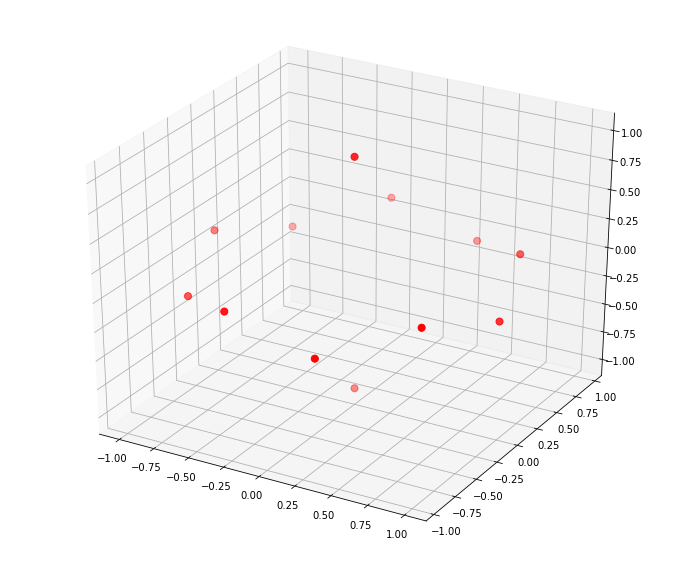

In [154]:
X, Y, Z = vertex_buffer.T
from mpl_toolkits.mplot3d import axes3d
figure(figsize=(12,10))
ax = subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='r', s=200, cmap='jet', marker='.');

In [20]:
index_buffer = array(
    [(0, 2 + k, 2 + (k+1) % N) for k in range(N)] +
    [(2 + (k+1) % N, 2 + k, 2 + N + (k+1) % N) for k in range(N)] +
    [(1, 2 + N + (k+1) % N, 2 + N + k) for k in range(N)] +
    [(2 + N + k, 2 + N + (k+1) % N, 2 + k) for k in range(N)],
dtype=uint32)
index_buffer

array([[ 0,  2,  3],
       [ 0,  3,  4],
       [ 0,  4,  5],
       [ 0,  5,  6],
       [ 0,  6,  2],
       [ 3,  2,  8],
       [ 4,  3,  9],
       [ 5,  4, 10],
       [ 6,  5, 11],
       [ 2,  6,  7],
       [ 1,  8,  7],
       [ 1,  9,  8],
       [ 1, 10,  9],
       [ 1, 11, 10],
       [ 1,  7, 11],
       [ 7,  8,  2],
       [ 8,  9,  3],
       [ 9, 10,  4],
       [10, 11,  5],
       [11,  7,  6]], dtype=uint32)

In [21]:
seed(0)
color_buffer = rand(len(vertex_buffer), 3).astype(float32)
color_buffer

array([[ 0.54881352,  0.71518934,  0.60276335],
       [ 0.54488319,  0.42365479,  0.64589411],
       [ 0.4375872 ,  0.89177299,  0.96366274],
       [ 0.38344151,  0.79172504,  0.5288949 ],
       [ 0.56804454,  0.92559665,  0.07103606],
       [ 0.0871293 ,  0.0202184 ,  0.83261985],
       [ 0.77815676,  0.87001216,  0.97861832],
       [ 0.79915857,  0.46147937,  0.7805292 ],
       [ 0.11827443,  0.63992101,  0.14335328],
       [ 0.94466889,  0.52184832,  0.41466194],
       [ 0.2645556 ,  0.7742337 ,  0.45615032],
       [ 0.56843394,  0.0187898 ,  0.61763549]], dtype=float32)

## Отрисовка модели из вершинного и индексного буферов

In [22]:
vertex_shader_source = '''
#version 330 core

layout (location = 0) in vec3 aPosition;
layout (location = 1) in vec3 aColor;

flat out vec3 Color;

uniform mat4 M_world, M_view, M_proj;

void main(void) {
    gl_Position = M_proj * M_view * M_world * vec4(aPosition, 1.0);
    Color = aColor;
}
'''

In [23]:
fragment_shader_source = '''
#version 330 core

flat in vec3 Color;
out vec4 FragColor;

void main(void) {
    FragColor = vec4(Color, 1.0);
}
'''

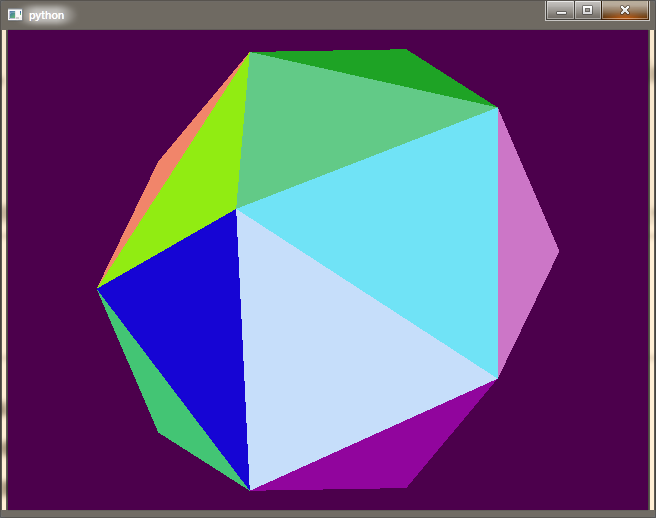

In [24]:
class GLWidget(ModelViewerWidget):
    def __init__(self, parent=None):
        super(GLWidget, self).__init__(parent)
        self.projection = 'ortho'
        
    def initializeGL(self):
        self.program = compileProgram(
            compileShader(vertex_shader_source, GL_VERTEX_SHADER),
            compileShader(fragment_shader_source, GL_FRAGMENT_SHADER),
        )
        glUseProgram(self.program)
        
        self.vao = make_vao(vertex_buffer, color_buffer)
        
        super(GLWidget, self).initializeGL()

    def paintGL(self):
        super(GLWidget, self).paintGL()

        glBindVertexArray(self.vao)
        glDrawElements(GL_TRIANGLES, index_buffer.size, GL_UNSIGNED_INT, index_buffer)
        glBindVertexArray(0)

run_qt_and_screenshot(GLWidget)

## Шейдер без геометрии

Проиллюстрируем мощь шейдеров лайтсаберами. Математика описана https://sharpc.livejournal.com/79180.html . Основную работу делает пиксельный шейдер, который по координатам пикселя и текущему времени рисует красоту.

In [405]:
vertex_shader_code = '''
#version 330 core
in vec3 aPos;
uniform float time;
out vec3 Position;

void main(void) {
    gl_Position = vec4(aPos, 1.);
    Position = aPos;
}
'''

In [406]:
fragment_shader_code = '''
#version 330 core
in vec3 Position;
uniform float time;

out vec4 FragColor;

// int((a*x+b) / sqrt(A*x^2+B*x+C)^3, x=0..1)
float integral(float a, float b, float A, float B, float C)
{
    return 2.0 * ((a * (B+C+C) - b * (A+A+B)) / sqrt(A + B + C) - (2.0 * a * C - b * B) / sqrt(C)) / (B * B - 4.0 * A * C);
}

// Освещение точки P с нормалью N линейным источником AB, нормированное длиной источника
float newosv(vec3 P, vec3 N, vec3 A, vec3 B)
{
    vec3 V = B - A;
    vec3 W = A - P;
    float a = dot(N,V);
    float b = dot(N,W);
    float c = dot(V,V);
    float d = 2.0 * dot(V,W);
    float e = dot(W,W);
    float result = integral(a, b, c, d, e);
    float diffuse = result < 0.0 ? 0.0 : result;
    return diffuse * distance(A, B) / 4.0;
}

// Отражение по одной координате
float modreflect1d(float a, float ma, float mb)
{
    float pos = mod(a - ma, 2.0 * (mb - ma));
    return min(pos, 2.0 * (mb - ma) - pos) + ma;
}

// Отражение вектора по трем координатам
vec3 modreflect3d(vec3 a, float minx, float maxx, float miny, float maxy, float minz, float maxz)
{
    return vec3(modreflect1d(a.x, minx, maxx), modreflect1d(a.y, miny, maxy), modreflect1d(a.z, minz, maxz));
}

const float pi = 3.14159265358979323846;

void main(void) {
    vec4 color;
    vec3 p = Position.xyz;
    float zdist = 0.2;

    // Звездочка
    const int n = 10;
    const int conn = 2;
    vec3 b1[n], b2[n], a1[n], a2[n];
    for (int i = 0; i < n; i += 2) {
        float phi0 = float(i) * 2.0 * pi / float(n) + pi / 2.0;
        float phi2 = float(i + conn * 2) * 2.0 * pi / float(n) + pi / 2.0;
        float r = 0.9;
        b1[i  ] = vec3(r * cos(phi0), r * sin(phi0), zdist);
        b1[i+1] = vec3(r * cos(phi2), r * sin(phi2), zdist);
        b2[i  ] = vec3(r / 1.5 * cos(phi0) + 0.5, r / 1.5 * sin(phi0) + 0.5, zdist);
        b2[i+1] = vec3(r / 1.5 * cos(phi2) + 0.5, r / 1.5 * sin(phi2) + 0.5, zdist);
    }

    // Скорость
    vec3 v1 = vec3(pi, sqrt(5.0), 1.0) / 10.0;
    vec3 v2 = vec3(sqrt(2.0), -pi, -0.5) / 10.0;
    // Вектор нормали к плоскости
    vec3 N = vec3(0.0, 0.0, 1.0);

    // Считаем координаты концов отрезков после отражений
    for (int i = 0; i < n; ++i) {
        a1[i] = modreflect3d(b1[i] + v1 * time, -1.0, 1.0, -1.0, 1.0, 0.1, 0.2);
        a2[i] = modreflect3d(b2[i] + v2 * time, -1.0, 1.0, -1.0, 1.0, 0.1, 0.2);
    }

    vec3 c1 = vec3(
        (sin(time) + 1.0) / 2.0,
        (sin(time + pi / 3.0) + 1.0) / 2.0,
        (sin(time + 2.0 * pi / 3.0) + 1.0) / 2.0
    );
    vec3 c2 = vec3(
        (sin(time * 0.9 + pi / 3.0) + 1.0) / 2.0,
        (sin(time * 0.9 + 2.0 * pi / 3.0) + 1.0) / 2.0,
        (sin(time * 0.9 + pi) + 1.0) / 2.0
    );

    // Считаем освещение
    float lum1 = 0.0, lum2 = 0.0;
    for (int i = 0; i < n; i += 2) {
        lum1 += newosv(p, N, a1[i], a1[i + 1]);
        lum2 += newosv(p, N, a2[i], a2[i + 1]);
    }
    lum1 /= float(n);
    lum2 /= float(n);

    vec3 lum = (lum1 * c1 + lum2 * c2) * 1.5;

    // Расчет "радужного" цвета
    FragColor = vec4(lum.xyz, 1.0);
}
'''

Этот шейдер не использует геометрию, а просто рисует пиксели, поэтому в качестве полигонов используются 2 треугольника, образующих квадрат на все окно.

In [407]:
vertex_buffer = array([
    (-1.0, -1.0),
    (1.0, -1.0),
    (1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, -1.0),
    (1.0, 1.0),
], float32)

In [408]:
class GLWidget(ModelViewerWidget):
    def __init__(self, parent=None):
        super(GLWidget, self).__init__(parent)

    def initializeGL(self):
        # Компилируем и делаем активными пару шейдеров
        self.program = compileProgram(
            compileShader(vertex_shader_code, GL_VERTEX_SHADER),
            compileShader(fragment_shader_code, GL_FRAGMENT_SHADER),
        )
        glUseProgram(self.program)

        # Чтобы передавать в шейдер время
        self.start_time = time.time()
        self.time_location = glGetUniformLocation(self.program, 'time')
        
        self.vao = make_vao(vertex_buffer)
        
        super(GLWidget, self).initializeGL()

    def resizeGL(self, width, height):
        side = min(width, height)
        # Рисуем в квадрат по центру окна
        glViewport(int((width - side) / 2), int((height - side) / 2), side, side)

    def paintGL(self):
        super(GLWidget, self).paintGL()
        
        # Передаем шейдеру прошедшее с начала работы время
        current_time = time.time() - self.start_time
        glUniform1f(self.time_location, current_time)

        glBindVertexArray(self.vao)
        glDrawArrays(GL_TRIANGLES, 0, len(vertex_buffer))
        glBindVertexArray(0)

Окно для отрисовки OpenGL можно сочетать с обычными виджетами Qt.

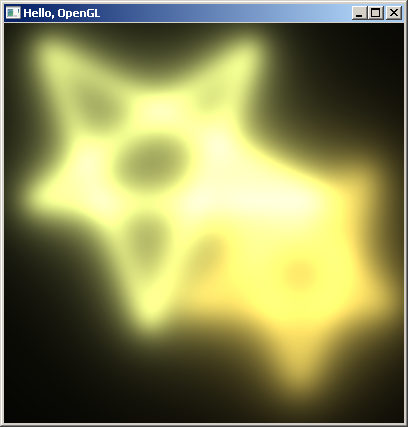

In [409]:
class MainWindow(QWidget):
    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)
        self.setWindowTitle('Hello, OpenGL')
        self.resize(400, 400)
        layout = QHBoxLayout()
        layout.setContentsMargins(0, 0, 0, 0)
        gl = GLWidget()
        layout.addWidget(gl)
        self.setLayout(layout)

run_qt_and_screenshot(MainWindow)

## Сложные модели

В сложных графических программах, например, играх, вершинные координаты и К не вбивают в массивы, а загружают из файлов, подготовленных 3D-художниками.

Библиотека `PyAssimp` это враппер над библиотекой assimp, поддерживающей свыше 40 форматов 3D-моделей https://github.com/assimp/assimp . Некоторое количество бесплатных 3D-моделей можно найти на https://free3d.com/3d-models/ .

```
pip install PyAssimp
скачать и установить assimp-sdk https://github.com/assimp/assimp/releases
```

In [25]:
import os
# PyAssimp не очень-то умеет находить нужную DLL от assimp
os.environ['Path'] = r'c:\Program Files\Assimp\bin\x64;' + os.environ['Path']
import pyassimp

todo Сорс модели протух?

In [26]:
model_filename = "do_not_attach/ob61pej2fz-Enginer/MP_US_Engi.FBX"

Нет костей, нужно мультитекстурирование из текстуры с защитным цветом?

In [28]:
scene = pyassimp.load(model_filename)
print len(scene.meshes), 'мешей'
print sum(len(mesh.vertices) for mesh in scene.meshes), 'вершин'
print sum(len(mesh.faces) for mesh in scene.meshes), 'полигонов'
print len(scene.materials), 'материалов'
pyassimp.release(scene)

7 мешей
39651 вершин
13217 полигонов
7 материалов


In [29]:
vertex_buffer = vstack([mesh.vertices for mesh in scene.meshes]) * array([1.0, 1.0, 1.0], float32)
print 'Вершинный буфер', vertex_buffer.dtype, vertex_buffer.shape
print vertex_buffer[:5]
print

normal_buffer = vstack([mesh.normals for mesh in scene.meshes])
print 'Буфер нормалей', normal_buffer.dtype, normal_buffer.shape
print normal_buffer[:5]
print

mesh_vertex_starts = cumsum([0] + [len(mesh.vertices) for mesh in scene.meshes])[:-1]
index_buffer = vstack([mesh.faces + offset for offset, mesh in zip(mesh_vertex_starts, scene.meshes)])
print 'Индексный буфер', index_buffer.dtype, index_buffer.shape
print index_buffer[:5]
print

color_buffer = []
for mesh in scene.meshes:
    color = mesh.material.properties.get(('diffuse', 0), [1.0, 0.0, 1.0])
    color_buffer += list(tile(array(color)[newaxis,:], (len(mesh.vertices), 1)))
color_buffer = array(color_buffer, float32)
print 'Буфер цвета', index_buffer.dtype, index_buffer.shape
print color_buffer[:5]
print

texcoord_buffer = vstack([mesh.texturecoords[0] for mesh in scene.meshes])
print 'Буфер текстурных координат', texcoord_buffer.dtype, texcoord_buffer.shape
print texcoord_buffer[:5]
print

Вершинный буфер float32 (39651L, 3L)
[[  8.12377930e+00  -1.03591901e-06   1.60058594e+02]
 [  8.41064453e+00  -6.90467298e-01   1.62207031e+02]
 [  8.12377930e+00  -1.12983025e-06   1.62207031e+02]
 [  8.41064453e+00  -6.90467298e-01   1.62207031e+02]
 [  8.12377930e+00  -1.03591901e-06   1.60058594e+02]]

Буфер нормалей float32 (39651L, 3L)
[[ -9.23470080e-01  -3.83670449e-01  -2.78290955e-08]
 [ -6.71216965e-01  -7.41260946e-01  -4.42425225e-08]
 [ -9.23470080e-01  -3.83670449e-01  -2.78290955e-08]
 [ -9.23470080e-01  -3.83670449e-01  -2.78290955e-08]
 [ -9.23470080e-01  -3.83670449e-01  -2.78290937e-08]]

Индексный буфер int32 (13217L, 3L)
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]

Буфер цвета int32 (13217L, 3L)
[[ 0.588  0.588  0.588]
 [ 0.588  0.588  0.588]
 [ 0.588  0.588  0.588]
 [ 0.588  0.588  0.588]
 [ 0.588  0.588  0.588]]

Буфер текстурных координат float32 (39651L, 3L)
[[ 0.63427734  0.26708984  0.        ]
 [ 0.64599609  0.29882812  0.        ]
 [ 0.63

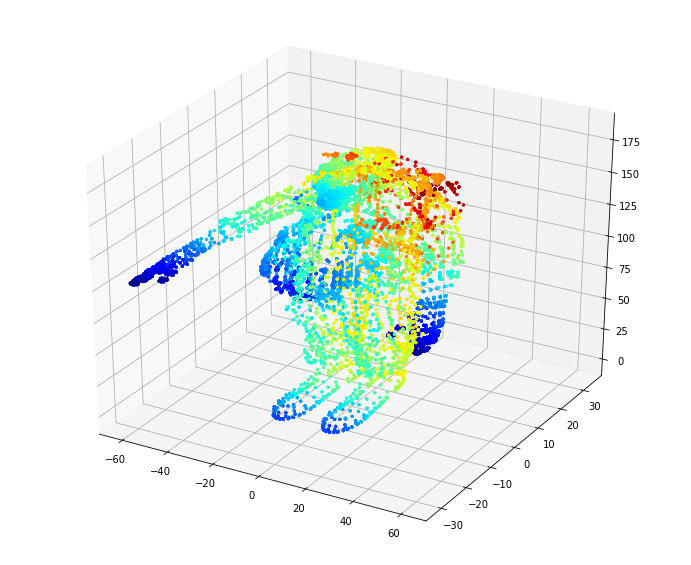

In [30]:
X, Y, Z = vertex_buffer.T
from mpl_toolkits.mplot3d import axes3d
figure(figsize=(12,10))
ax = subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=Y, cmap='jet', marker='.');

In [31]:
def calculateBbox(scene):
    bbox = None
    for mesh in scene.meshes:
        for vert in mesh.vertices:
            if bbox is None:
                bbox = [array(vert), array(vert)]
            bbox[0] = amin([bbox[0], array(vert)], axis=0)
            bbox[1] = amax([bbox[1], array(vert)], axis=0)
    return bbox

bbox = calculateBbox(scene)
print bbox
print bbox[1] - bbox[0]

[array([-61.27929688, -31.25000381,  -0.37918124], dtype=float32), array([  61.42578125,   33.47167587,  182.03125   ], dtype=float32)]
[ 122.70507812   64.72167969  182.41043091]


182? У послушных детей координаты моделей в единицах СИ (метры).

## Текстурирование

todo

    glUniform1i(glGetUniformLocation(shaderProgram, "tex0"), 0) # 0 из GL_TEXTURE0, можно минимум до 48
    
в шейдере

    uniform sampler2D tex0;

GL_TEXTURE_MIN_FILTER and GL_TEXTURE_MAG_FILTER - использовать такой способ фильтрации, если пиксель больше текселя или меньше
GL_NEAREST | GL_LINEAR -- брать ближайший тексель или усреднять несколько
можно использовать GL_NEAREST_MIPMAP_LINEAR -- NEAREST_MIPMAP использовать ближайший мипмэп или усреднять соседние, NEAREST|LINEAR -- тексели из мипмэпа(ов)

In [32]:
def bind_texture(slot, arr):
    height, width, channels = arr.shape
    if arr.dtype == float32:
        arr = (arr * 255).astype(uint8)
    assert channels >= 3 and arr.dtype == uint8
    tex = glGenTextures(1)
    glActiveTexture(slot)
    glBindTexture(GL_TEXTURE_2D, tex)
    glPixelStorei(GL_UNPACK_ALIGNMENT, 1)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, width, height, 0, GL_RGB, GL_UNSIGNED_BYTE, arr[:,:,:3])
    # Как брать цвет текселя, если пиксель больше/меньше его
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    # Как трактовать текстурные координаты за пределами [0,1]x[0,1]
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_S, GL_REPEAT);
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_T, GL_REPEAT);
    #glTexEnvf(GL_TEXTURE_ENV, GL_TEXTURE_ENV_MODE, GL_DECAL)
    # Сгенерировать копии текстуры с другим разрешением
    glGenerateMipmap(GL_TEXTURE_2D)
    return tex

In [33]:
vertex_shader_code = '''
#version 330 core
layout (location = 0) in vec3 aPosition;
layout (location = 1) in vec3 aNormal;
layout (location = 2) in vec2 aTexcoord;

uniform mat4 M_world, M_view, M_proj;

out vec4 PositionView;
out vec4 Normal;
out vec3 SrcNormal;
out vec2 Texcoord;

void main(void)
{
    gl_Position = M_proj * M_view * M_world * vec4(aPosition, 1.0);
    PositionView = M_view * M_world * vec4(aPosition, 1.0);
    Normal = M_view * M_world * vec4(aNormal, 0.0);
    SrcNormal = aNormal;
    Texcoord = aTexcoord;
}
'''

Львиная доля реализма компьютерной графики зависит от **модели освещения**. Много враиантов собраны тут: http://steps3d.narod.ru/tutorials/lighting-tutorial.html . Классическая модель Фонга суммирует 3 компоненты освещения:
* ambient, константа для всей сцены;
* diffuse, зависящий от косинуса угла падения света, пропорционален $(\vec{N}, \vec{L})$ — скалярному произведению нормали поверхности $\vec{N}$ на вектор направления света на пиксель $\vec{L}$ (здесь и далее вектора считаются единичными);
* specular, зависящий от косинуса угла между вектором отражения $\vec{R}$ и вектором от пикселя в глаз $\vec{E}$, пропорционален $(\vec{R}, \vec{E})^\rho$, где степень $\rho$ зависит от степени зеркальности поверхности.

https://en.wikipedia.org/wiki/Specular_highlight

https://en.wikipedia.org/wiki/Fresnel_equations

https://en.wikipedia.org/wiki/Schlick%27s_approximation

http://www.gamedev.ru/code/articles/cook-torrance

https://habr.com/post/326852/ Готовим Physically Based Rendering + Image-based Lighting. Теория+практика. Шаг за шагом

https://iondune.github.io/csc476/lectures/15-cook-torrance

In [34]:
fragment_shader_code = '''
#version 330 core
in vec4 PositionView;
in vec4 Normal;
in vec3 SrcNormal;
in vec2 Texcoord;

uniform sampler2D texture_duffuse;
uniform sampler2D texture_normal_mapping;

uniform vec3 MaterialAmbient;
uniform vec3 MaterialDiffuse;
uniform vec3 MaterialSpecular;
uniform vec3 MaterialEmissive;
uniform float MaterialShininess;

uniform int mode;

out vec4 FragColor;

const vec4 LightSourcePosition = vec4(0.0, 0.0, 0.0, 1.0);
const vec3 LightSourceColor = vec3(1.0, 1.0, 1.0);

void main(void)
{
    vec3 L = normalize(LightSourcePosition.xyz - PositionView.xyz);
    vec3 E = normalize(-PositionView.xyz); // в видовых координатах PositionCamera = (0,0,0)
    vec3 N = normalize(Normal.xyz);
    vec3 R = -reflect(L, N);

    float Idiffuse = max(dot(N, L), 0.0);
    Idiffuse = clamp(Idiffuse, 0.0, 1.0);
    float Ispecular = pow(max(dot(R, E), 0.0), 0.3 * MaterialShininess);
    Ispecular = clamp(Ispecular, 0.0, 1.0);



    // Cook-Torrance
    vec3  H    = normalize(L + E);

    float nh   = dot ( N, H );
    float nv   = dot ( N, E );
    float nl   = dot ( N, L );

    float roughness = 0.02;

    float r2   = roughness * roughness;
    float nh2  = nh * nh;
    float ex   = -(1.0 - nh2) / (nh2 * r2);
    float d    = exp(ex) / (r2 * nh2 * nh2);

    float r0 = pow((1.5-1.0)/(1.5+1.0), 2.0);

    float f    = mix ( pow ( 1.0 - nv, 5.0 ), 1.0, r0 );
    float x    = 2.0 * nh / dot ( E, H );
    float g    = min ( 1.0, min ( x * nl, x * nv ) );
    float ct   = d*f*g / nv;

    Ispecular = max ( 0.0, ct );



    vec3 Cambient = LightSourceColor * MaterialAmbient;
    vec3 Cdiffuse = LightSourceColor * MaterialDiffuse * Idiffuse;
    vec3 Cspecular = LightSourceColor * MaterialSpecular * Ispecular;
    
    vec4 textureColor = texture(texture_duffuse, Texcoord.st);
    vec4 textureNormal = normalize(2.0 * texture(texture_normal_mapping, Texcoord.st) - 1.0);
    
    vec3 Clight = Cambient + Cdiffuse + Cspecular;
    FragColor = textureColor * vec4(Clight, 1.0);
    
    if (mode == 1) {
        FragColor = textureColor;
    } else if (mode == 2) {
        FragColor = vec4(Texcoord.st, 0.0, 1.0);
    } else if (mode == 3) {
        FragColor = textureNormal; //Iambient;
    } else if (mode == 4) {
        FragColor = vec4(Cdiffuse, 1.0);
    } else if (mode == 5) {
        FragColor = vec4(Cspecular, 1.0);
    } else if (mode == 6) {
        FragColor = vec4(Clight, 1.0);
    } else if (mode == 7) {
        FragColor = dot(N, L) >= 0.0 ? vec4(1.0, 0.5, 0.0, 1.0) : vec4(0.5, 0.0, 0.5, 1.0);
    } else if (mode == 8) {
        FragColor = vec4(normalize(SrcNormal.xyz), 1.0);
    } else if (mode == 9) {
        float depth = length(PositionView.xyz) / 300.0;
        FragColor = vec4(depth, depth, depth, 1.0);
    } else if (mode == 0) {
        FragColor = textureColor * vec4(Clight, 1.0);
    }
}
'''

todo Описание передачи буферов на GPU

In [36]:
(bbox[1][1] - bbox[0][1]) * 0.618 + bbox[0][1]

8.7479942321777315

..\..\Frame0001\Tex_0018_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0018_1.jpg
..\..\Frame0001\Tex_0022_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0022_1.jpg
..\..\Frame0001\Tex_0022_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0022_1.jpg
..\..\Frame0001\Tex_0024_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0024_1.jpg
..\..\Frame0001\Tex_0027_1.dds ..\..\Frame0001\Tex_0019_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0019_1.jpg
..\..\Frame0001\Tex_0021_1.dds -> do_not_attach\ob61pej2fz-Enginer\Textures\Tex_0021_1.png


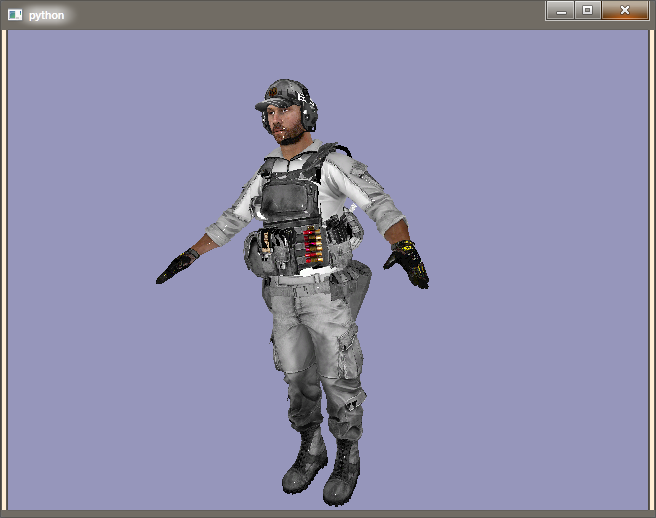

In [46]:
class GLWidget(ModelViewerWidget):
    def __init__(self, parent=None):
        super(GLWidget, self).__init__(parent)
        self.distance = 200.0
        self.distance_speed = 10
        self.mode = 0
        self.clear_color = QColor.fromCmykF(0.39, 0.39, 0.0, 0.0).darker().getRgbF()
        #self.x = -20.0
        self.y = -100.0
        self.fov = 45.0

    def initializeGL(self):
        self.program = compileProgram(
            compileShader(vertex_shader_code, GL_VERTEX_SHADER),
            compileShader(fragment_shader_code, GL_FRAGMENT_SHADER),
        )
        glUseProgram(self.program)

        self.vao = make_vao(vertex_buffer, normal_buffer, texcoord_buffer, index_buffer=index_buffer)

        texIdx = 1
        self.texIndices = {}
        for i, material in enumerate(scene.materials):
            filename = material.properties.get(('file', 1), None)
            if filename is not None:
                print filename,
                filename = filename.replace('..\\..\\Frame0001\\', 'Textures/')
                for rep in ['.png', '.jpg']:
                    filename2 = filename.replace('.dds', rep)
                    filename2 = os.path.normpath(os.path.join(os.path.dirname(model_filename), filename2))
                    if not os.path.exists(filename2):
                        continue
                    print '->', filename2
                    image = imread(filename2)[::-1,:,:]
                    bind_texture(GL_TEXTURE0 + texIdx, image)
                    self.texIndices[i] = texIdx
                    texIdx += 1
                    break

        super(GLWidget, self).initializeGL()


    def paintGL(self):
        super(GLWidget, self).paintGL()
        
        myUniformMode = glGetUniformLocation(self.program, "mode")
        glUniform1i(myUniformMode, self.mode)

        glBindVertexArray(self.vao)

        colors = [
            ('diffuse', GL_DIFFUSE, [0.8, 0.8, 0.8]),
            ('specular', GL_SPECULAR, [0., 0., 0.]),
            ('ambient', GL_AMBIENT, [0.2, 0.2, 0.2]),
            ('emissive', GL_EMISSION, [0., 0., 0.]),
            ('shininess', GL_SHININESS, 1.0),
        ]
        
        idx = 0
        for mesh in scene.meshes:
            mat = mesh.material
            glUniform1i(glGetUniformLocation(self.program, "texture_duffuse"), self.texIndices.get(mesh.materialindex, 0))
            
            for name, _, default in colors:
                color = mat.properties.get((name, 0), default)
                var_location = glGetUniformLocation(self.program, 'Material' + name.capitalize())
                if name == 'shininess':
                    glUniform1f(var_location, min(color, 128.0))
                else:
                    glUniform3f(var_location, *color)

            glEnable(GL_FRAMEBUFFER_SRGB)
            glDrawElements(GL_TRIANGLES, len(mesh.faces) * 3, GL_UNSIGNED_INT, ctypes.c_void_p(idx * 4))
            idx += len(mesh.faces) * 3

    def keyPressEvent(self, event):
        super(GLWidget, self).keyPressEvent(event)
        if event.key() >= Qt.Key_0 and event.key() <= Qt.Key_9:
            self.mode = event.key() - Qt.Key_0
            import re
            what = re.match(r'.*mode == %d\) \{.*?FragColor = (.*?);\s*\}' % self.mode, fragment_shader_code, re.S)
            if what:
                what = what.groups()[0]
                self.setWindowTitle(what)


run_qt_and_screenshot(GLWidget)

todo жуткий z-fighting

3D художники, делающие свободные модели, весьма наплевательски относятся к корректности путей к текстурам.

In [47]:
[list(m.properties.keys()) for m in scene.materials]

[['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  'specular',
  'file',
  'shininess'],
 ['uvwsrc',
  'uvtrafo',
  'shinpercent',
  'diffuse',
  'opacity',
  'ambient',
  'transparent',
  'name',
  's

In [48]:
for mesh in scene.meshes:
    print mesh.materialindex, mesh.material.properties

0 {('uvwsrc', 1L): 0, ('uvtrafo', 1L): [0.0, 0.0, 1.0, 1.0, 0.0], ('shinpercent', 0L): 0.0, ('diffuse', 0L): [0.5879999995231628, 0.5879999995231628, 0.5879999995231628], ('opacity', 0L): 1.0, ('ambient', 0L): [0.5879999995231628, 0.5879999995231628, 0.5879999995231628], ('transparent', 0L): [1.0, 1.0, 1.0], ('name', 0L): u'Tex_0018_1.dds', ('specular', 0L): [0.8999999761581421, 0.8999999761581421, 0.8999999761581421], ('file', 1L): u'..\\..\\Frame0001\\Tex_0018_1.dds', ('shininess', 0L): 2.0}
1 {('uvwsrc', 1L): 0, ('uvtrafo', 1L): [0.0, 0.0, 1.0, 1.0, 0.0], ('shinpercent', 0L): 0.0, ('diffuse', 0L): [0.5879999995231628, 0.5879999995231628, 0.5879999995231628], ('opacity', 0L): 1.0, ('ambient', 0L): [0.5879999995231628, 0.5879999995231628, 0.5879999995231628], ('transparent', 0L): [1.0, 1.0, 1.0], ('name', 0L): u'Tex_0022_1.dds', ('specular', 0L): [0.8999999761581421, 0.8999999761581421, 0.8999999761581421], ('file', 1L): u'..\\..\\Frame0001\\Tex_0022_1.dds', ('shininess', 0L): 2.0}
2 

## Интерфейс пользователя

Самым доступным и удобным способом сделать интерфейс внутри графического окна является `QWebView`.

todo

QImage img(widget->size());

widget->render(&img);

QImage QGLWidget::convertToGLFormat ( const QImage & img )


QVariant есть метод toJsonValue()

https://stackoverflow.com/questions/39544089/how-can-i-access-python-code-from-javascript-in-pyqt-5-7

In [50]:
%pylab inline
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtNetwork import *
from PyQt5.QtWebKit import *
from PyQt5.QtWebKitWidgets import *

from PyQt5.QtOpenGL import *
from OpenGL.GL import *
from OpenGL.GL.shaders import *
from OpenGL.GLU import *

from ctypes import c_void_p

import math, sys, time, os
QT_VERSION_STR

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


'5.6.2'

In [52]:
from ultra import file_get

In [53]:
import PIL.Image
from io import BytesIO

pixmap = None
def run_qt_and_screenshot(WindowClass, method='pyqt5', fullscreen=False):
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication([])

    def closeEvent(self, event):
        global pixmap
        rect = self.frameGeometry()
        dw = QDesktopWidget()
        desktop_id = dw.screen(dw.screenNumber(self)).winId()
        if method == 'pyside':
            pixmap = QPixmap.grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        elif method == 'pyqt5':
            pixmap = QApplication.primaryScreen().grabWindow(desktop_id, rect.x(), rect.y(), rect.width(), rect.height())
        event.accept()
        
    WindowClass.closeEvent = closeEvent
    window = WindowClass()
    if fullscreen:
        window.showFullScreen() # .showNormal для переключения
    else:
        window.show()

    if method == 'pyside':
        try:
            from IPython.lib.guisupport import start_event_loop_qt4
            start_event_loop_qt4(app)
        except ImportError:
            app.exec_()
    elif method == 'pyqt5':
        app.exec_()

    io = QBuffer()
    pixmap.save(io, 'PNG')
    return PIL.Image.open(BytesIO(io.data().data()))

In [54]:
import logging, traceback
logg = logging.Logger('main')
logarr = []
class LogArrayHandler:
    def __init__(self, arr):
        self.arr = arr
        self.level = 0 #logging.DEBUG
    def handle(self, record):
        self.arr.append(record)
logg.addHandler(LogArrayHandler(logarr))

In [55]:
class StringNetworkReply(QNetworkReply):
    def __init__(self, op, request, response):
        print 'StringNetworkReply', request, response
        super(StringNetworkReply, self).__init__()

        self.ba = QByteArray(response)
        self.data = QBuffer(self.ba)
        self.data.open(QBuffer.ReadOnly)

        self.setRequest(request)
        self.setOpenMode(QIODevice.ReadOnly)
        self.setOperation(op)
        self.setUrl(request.url())
        self.setHeader(QNetworkRequest.ContentTypeHeader, QVariant('text/html'))
        self.setHeader(QNetworkRequest.ContentLengthHeader, QVariant(QByteArray.number(len(response))))
        
        QTimer.singleShot(0, self.metaDataChanged.emit)
        QTimer.singleShot(0, self.readyRead.emit)
        QTimer.singleShot(0, self.finished.emit)

    def abort(self):
        self.setFinished(True)

    def readData(self, maxlen):
        l = self.data.readData(maxlen)
        self.data.seek(self.data.pos() + len(l))
        return l

In [56]:
class HUDNetworkManager(QNetworkAccessManager):
    def __init__(self, parent=None):
        super(HUDNetworkManager, self).__init__(parent)
        self.replies = []

    def createRequest(self, op, request, outgoingData):
        print op, request.url(); sys.stdout.flush()
        
        for reply in self.replies[:]:
            if reply.isFinished():
                print 'remove reply'; sys.stdout.flush()
                self.replies.remove(reply)
                del reply

        if request.url().scheme().startswith('http'):
            reply = StringNetworkReply(op, request, 'NOTHING TO SEE THERE')
            self.replies.append(reply)
            return reply

        return super(HUDNetworkManager, self).createRequest(op, request, outgoingData)

In [57]:
class JSConfigBridge(QObject):
    updateConfig = pyqtSignal('QVariantMap')

    def __init__(self, config, parent=None):
        super(JSConfigBridge, self).__init__(parent)
        self.config = config

    @pyqtSlot(result='QVariantMap')
    def getConfig(self):
        print 'JSConfigBridge::getConfig'; sys.stdout.flush()
        return self.config

    @pyqtSlot('QVariantMap')
    def setConfig(self, dic):
        print 'JSConfigBridge::setConfig', dic; sys.stdout.flush()
        self.config.update(dic)
        self.updateConfig.emit(dic)

In [58]:
class HUDWebPage(QWebPage):
    def __init__(self, parent=None):
        super(HUDWebPage, self).__init__(parent)
    def javaScriptConsoleMessage(self, msg, line, source):
        print '%s line %d: %s' % (source, line, msg); sys.stdout.flush()

In [59]:
class HUDWebView(QWebView):
    #redrawed = pyqtSignal(QImage, QRect)
    updateConfig = pyqtSignal('QVariantMap')

    def __init__(self, parent=None):
        super(HUDWebView, self).__init__(parent)
        self.setAttribute(Qt.WA_DontShowOnScreen)
        #self.show()

        self.pageobj = HUDWebPage(self)
        self.setPage(self.pageobj)
        self.page().repaintRequested.connect(self.repaintRequested)
        
        qpalette = self.palette()
        qpalette.setBrush(QPalette.Base, Qt.transparent)
        self.page().setPalette(qpalette)
        # it does not paint all the pixels contained in its rectangle
        self.setAttribute(Qt.WA_OpaquePaintEvent, False)
        self.setAttribute(Qt.WA_TranslucentBackground, True)

        self.page().setNetworkAccessManager(HUDNetworkManager(self))

        self.repaintCallback = None
        
        self.bmp = None
        #self.createBitmap(self.width(), self.height())

        self.bridge = JSConfigBridge({'some': 'cook'})
        self.bridge.updateConfig.connect(lambda upd: self.updateConfig.emit(upd))
        self.page().mainFrame().javaScriptWindowObjectCleared.connect(self.attachBridge)
        self.page().mainFrame().loadFinished.connect(self.attachBridge)

    def attachBridge(self):
        logg.debug('HUDWebView::attachBridge')
        self.page().mainFrame().addToJavaScriptWindowObject("HostBridge", self.bridge)
        self.page().mainFrame().evaluateJavaScript('if (window.HostBridgeInit) { HostBridgeInit(); }')

    def createBitmap(self, width, height):
        # Картинка с альфа-каналом на все окно
        logg.debug('HUDWebView::createBitmap', width, height)
        #self.bmp.append( QImage(width, height, QImage.Format_ARGB32) )
        self.bmp = QImage(width, height, QImage.Format_ARGB32)
        self.bmp.fill(0)

    def everySize(self):
        return '[self.size() = %s  self.bmp.size() = %s]' % (
            repr(self.size()), repr(self.bmp.size()) if self.bmp else 'None'
        )
        
    def setGeometry(self, a, b, c, d):
        logg.debug('HUDWebView::setGeometry', a, b, c, d)
        
    def resize(self, width, height):
        call = 'HUDWebView::resize(%d, %d)' % (width, height)
        logg.debug(call, self.everySize(), 'next - show')
        self.show()
        logg.debug(call, self.everySize(), 'next - super')
        super(HUDWebView, self).resize(width, height)
        logg.debug(call, self.everySize(), 'next - hide')
        #QApplication.processEvents()
        self.hide()
        logg.debug(call, self.everySize(), 'next - return')
        
    def resizeEvent(self, event):
        call = 'HUDWebView::resizeEvent(event=%s -> %s)' % (repr(event.oldSize()), repr(event.size()))
        if event.oldSize().width() == 640 and event.size().width() == 640:
            return
            pass
            #logg.warn(traceback.extract_stack())
        logg.debug(call, self.everySize(), 'next - createBitmap')
        self.createBitmap(event.size().width(), event.size().height())
        logg.debug(call, self.everySize(), 'next - super')
        super(HUDWebView, self).resizeEvent(event)
        logg.debug(call, self.everySize(), 'next - return')

    def setRepaintCallback(self, callback):
        self.repaintCallback = callback
    
    def repaintRequested(self, rect):
        call = 'HUDWebView::repaintRequested(rect=%s)' % repr(rect)
        w, h = self.width(), self.height()
        logg.debug(call, self.everySize())
        if rect.left() < 0 or rect.top() < 0 or rect.right() >= w or rect.bottom() >= h:
            logg.warn('HUDWebView::repaintRequested tries to draw outside of window', w, h)
            #return
        #if not self.bmp or (self.bmp.width(), self.bmp.height()) != (w, h):
        #    self.createBitmap(self.width(), self.height())
        p = QPainter(self.bmp)
        p.setBackgroundMode(Qt.TransparentMode)
        p.setCompositionMode(QPainter.CompositionMode_Source)
        p.begin(self.bmp)
        p.fillRect(rect, QColor(0,0,0,0))
        self.render(p, QPoint(rect.left(), rect.top()), QRegion(rect))
        p.end()
        if self.repaintCallback:
            self.repaintCallback(self.bmp, rect)

In [60]:
def SetOrtho(ratio):
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    glOrtho(-ratio, ratio, -1.0, 1.0, 0.1, 100)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()

def SetPerspective(ratio):
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluPerspective(120, ratio, 0.1, 100)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()


class GLWidget(QGLWidget):
    def __init__(self, parent=None):
        fmt = QGLFormat()
        fmt.setSwapInterval(1)
        super(GLWidget, self).__init__(fmt, parent)
        
        self.isRenderHUDOn = True
        
        self.wv = HUDWebView()

        self.setAttribute(Qt.WA_NoSystemBackground)
        self.setMouseTracking(True)
        self.setFocusPolicy(Qt.StrongFocus)

        self.ratio = 1.0

        self.prevFpsTime = 0
        self.prevFpsFrame = 0
        self.frame = 0
        self.timer_elapsed = QTime()
        self.timer_elapsed.start()

    def resizeGL(self, width, height):
        logg.debug('GLWidget::resizeGL', width, height)
        
        glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, width, height, 0, GL_RGBA, GL_UNSIGNED_BYTE, None)
        self.textureWidth, self.textureHeight = width, height

        self.wv.resize(width, height)

        self.ratio = float(width) / height
        glViewport(0, 0, width, height)
        SetPerspective(self.ratio)
        logg.debug('GLWidget::resizeGL finish', width, height)
        
    def initializeGL(self):
        logg.debug('GLWidget::initializeGL')
        glEnable(GL_ALPHA_TEST)
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)

        glEnable(GL_DEPTH_TEST)
        glEnable(GL_COLOR_MATERIAL)
        glEnable(GL_LIGHTING)
        glEnable(GL_LIGHT0)
        pos = array([3, 6, 10], dtype=float32)
        glLightfv(GL_LIGHT0, GL_POSITION, pos)

        glEnable(GL_TEXTURE_2D)
        self.texture = glGenTextures(1)
        glBindTexture(GL_TEXTURE_2D, self.texture)
        glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
        glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
        #glBindTexture(GL_TEXTURE_2D, texture)
        #glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, image.width(), image.height(), 0, GL_RGBA, GL_UNSIGNED_BYTE, None)
        #glTexSubImage2D(GL_TEXTURE_2D, 0, 0, 0, image.width(), image.height(), GL_RGB, GL_UNSIGNED_BYTE, array(im))
        self.textureWidth, self.textureHeight = None, None

        HTML = file_get('files/hud/hud.html')
        self.wv.setHtml(HTML, QUrl.fromLocalFile(os.path.realpath('files/hud/hud.html')))
        self.wv.setRepaintCallback(self.on_hud_redraw)

        self.timer = QTimer()
        #self.timer.timeout.connect(self.own_updateGL)
        self.timer.timeout.connect(self.updateGL)
        self.timer.start(16)

    def showFPS(self, el):
        #self.parent().setWindowTitle('%d' % el)
        if el - self.prevFpsTime > 1000:
            fps = float(self.frame - self.prevFpsFrame) / (el - self.prevFpsTime) * 1000
            self.prevFpsFrame = self.frame
            self.prevFpsTime = el

            # Размер вьюпорта и fps в заголовок окна
            text = 'FPS: %d | %dx%d' % (fps, self.width(), self.height())
            self.parent().setWindowTitle(text)

        self.frame += 1

    def renderModel(self, phase):
        #logg.debug('GLWidget::renderModel')
        SetPerspective(self.ratio)
        # Рисуем цилиндр
        q = gluNewQuadric()
        glPushMatrix()
        glTranslatef(0.0, 0.0, -8.0)
        glRotated(phase * 360, 0.0, 1.0, 0.5)
        glTranslatef(-5.0, 0.0, 0.0)
        glRotatef(90, 0.0, 1.0, 0.0)
        glColor3f(0.0, 0.5, 1.0)
        gluCylinder(q, 0.2, 0.2, 10.0, 10, 10)
        glPopMatrix()
        gluDeleteQuadric(q)

        # Рисуем сферу
        for xxx in arange(-5.0, 5.0 + 0.01, 5.0):
            q2 = gluNewQuadric()
            glPushMatrix()
            glTranslatef(0.0, 0.0, -8.0)
            glRotated(phase * 360, 0.0, 1.0, 0.5)
            glTranslatef(xxx, 0.0, 0.0)
            glColor3f(1.0, 0.5, 0.0)
            gluSphere(q2, 1.0, 10, 10)
            glPopMatrix()
            gluDeleteQuadric(q2)

    def renderHUD(self):
        #logg.debug('GLWidget::renderHUD')

        # Ортографическое проецирование
        SetOrtho(self.ratio)

        # С текстурой, без освещения, поверх всего
        glEnable(GL_TEXTURE_2D)
        glDisable(GL_LIGHTING)
        glDisable(GL_DEPTH_TEST)

        # Белый (чтобы текстура была без цветовых искажений) квад на весь экран
        glColor3f(1.0, 1.0, 1.0)
        glBegin(GL_QUADS)
        glTexCoord2f(0.0, 0.0); glVertex3f(-self.ratio, 1.0, -0.1)
        glTexCoord2f(1.0, 0.0); glVertex3f(self.ratio, 1.0, -0.1)
        glTexCoord2f(1.0, 1.0); glVertex3f(self.ratio, -1.0, -0.1)
        glTexCoord2f(0.0, 1.0); glVertex3f(-self.ratio, -1.0, -0.1)
        glEnd()

        glEnable(GL_DEPTH_TEST)
        glEnable(GL_LIGHTING)
        glDisable(GL_TEXTURE_2D)

    def paintGL(self):
        logg.debug('GLWidget::paintGL', {'frame': self.frame})
        el = self.timer_elapsed.elapsed()

        self.showFPS(el)
        phase = float(el % 10000) / 10000

        glClearColor(0.0, 0.5, 0.0, 0.0)
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

        self.renderModel(phase)

        if self.isRenderHUDOn:
            self.renderHUD()
        
    def on_hud_redraw(self, im, rect):
        logg.debug(
            'GLWidget::on_hud_redraw',
            'on im %dx%d' % (im.width(), im.height()),
            'rect %s' % repr(rect),
            'textureWH = %s' % repr((self.textureWidth, self.textureHeight))
        )
        if (im.width(), im.height()) != (self.textureWidth, self.textureHeight):
            #print 'recreate texture with (%d,%d)' % (im.width(), im.height()); sys.stdout.flush()
            logg.debug('GLWidget::on_hud_redraw recreate texture')
            glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, im.width(), im.height(), 0, GL_RGBA, GL_UNSIGNED_BYTE, None)
            self.textureWidth, self.textureHeight = im.width(), im.height()
        
        #logg.debug('GLWidget::on_hud_redraw get texture params')
        #w = glGetTexLevelParameteriv(GL_TEXTURE_2D, 0, GL_TEXTURE_WIDTH)
        #h = glGetTexLevelParameteriv(GL_TEXTURE_2D, 0, GL_TEXTURE_HEIGHT)
        #logg.debug('GLWidget::on_hud_redraw set window title')
        #self.setWindowTitle('tex: %dx%d im: %dx%d' % (w, h, im.width(), im.height()))
        #logg.debug('GL_TEXTURE_WIDTH|HEIGHT %s' % repr((w, h)))
        w, h = im.width(), im.height()
        
        if rect.top() < 0 or rect.left() < 0 or rect.bottom() >= h or rect.right() >= w:
            logg.warn('GLWidget::on_hud_redraw got rect out of tex size')
            return
        
        fragment = im.copy(rect)
        ptr = c_void_p(fragment.bits().__int__())
        glTexSubImage2D(
            GL_TEXTURE_2D, 0, rect.left(), rect.top(), fragment.width(), fragment.height(),
            GL_BGRA, GL_UNSIGNED_BYTE, ptr
        )
        logg.debug('GLWidget::on_hud_redraw return')


    def toggleHUD(self):
        self.isRenderHUDOn = not self.isRenderHUDOn
    def keyPressEvent(self, event):
        if event.key() == Qt.Key_Escape:
            self.toggleHUD()
        elif self.isRenderHUDOn:
            logg.debug('GLWidget::keyPressEvent')
            QCoreApplication.sendEvent(self.wv, event)
    def mouseMoveEvent(self, event):
        if self.isRenderHUDOn:
            logg.debug('GLWidget::mouseMoveEvent')
            QCoreApplication.sendEvent(self.wv, event)
    def wheelEvent(self, event):
        if self.isRenderHUDOn:
            logg.debug('GLWidget::wheelEvent')
            QCoreApplication.sendEvent(self.wv, event)
    def mousePressEvent(self, event):
        if self.isRenderHUDOn:
            logg.debug('GLWidget::mousePressEvent')
            QCoreApplication.sendEvent(self.wv, event);
    def mouseReleaseEvent(self, event):
        if self.isRenderHUDOn:
            logg.debug('GLWidget::mouseReleaseEvent')
            QCoreApplication.sendEvent(self.wv, event)

In [61]:
def QImage2pil(qimage):
    b = QBuffer()
    b.open(QIODevice.ReadWrite)
    qimage.save(b, "PNG")
    return PIL.Image.open(BytesIO(str(b.data())))

In [62]:
logarr[:] = []

2 PyQt5.QtCore.QUrl(u'file:///C:/Now/jupyter_code/infrastructure/files/hud/jquery-1.5.2.min.js')
2 PyQt5.QtCore.QUrl(u'file:///C:/Now/jupyter_code/infrastructure/files/hud/raphael-1.5.2.min.js')
2 PyQt5.QtCore.QUrl(u'file:///C:/Now/jupyter_code/infrastructure/files/hud/logo.png')
2 PyQt5.QtCore.QUrl(u'file:///C:/Now/jupyter_code/infrastructure/files/hud/anim.gif')
file:///C:/Now/jupyter_code/infrastructure/files/hud/hud.html line 46: isStandalone = false
file:///C:/Now/jupyter_code/infrastructure/files/hud/hud.html line 68: HostBridgeInit will be called by host
file:///C:/Now/jupyter_code/infrastructure/files/hud/hud.html line 33: HostBridgeInit
JSConfigBridge::getConfig
JSConfigBridge::getConfig
JSConfigBridge::setConfig {u'some': u'phong'}
file:///C:/Now/jupyter_code/infrastructure/files/hud/hud.html line 36: client updateConfig event
JSConfigBridge::getConfig
JSConfigBridge::getConfig
JSConfigBridge::setConfig {u'some': u'cook'}
file:///C:/Now/jupyter_code/infrastructure/files/hud/h

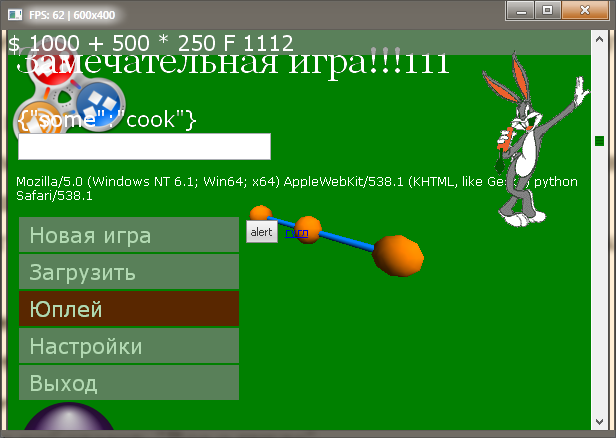

In [63]:
last_im = None

class MainWindow(QWidget):
    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)
        self.setWindowTitle('Hello, OpenGL')
        self.resize(600, 400)
        self.layout = QHBoxLayout()
        self.layout.setContentsMargins(0, 0, 0, 0)
        self.gl = GLWidget()
        
        self.diag = QLabel()
        #self.diag.show()

        self.layout.addWidget(self.gl)
        self.setLayout(self.layout)

run_qt_and_screenshot(MainWindow)

todo

Проблемы:
* браузер не перерисовывается при изменении дома по сигналу от объекта, вставленного в window
* GIF-анимация играется по большим праздникам
* шарик в SVG имеет проблемы с альфа-каналом, при скролле в картинке пропадает внутренность шарика
* квадрат вокруг стрелочки на скроллбаре и чередующиеся пиксели под баром прозрачные

* ~~при ресайзе текстура ресайзится до обновления~~
* ~~не работает колесо?~~
* ~~перехватывать веб-запросы~~
* веб-шрифты не работают, "Все о гугле"
* ~~выделение на картинке не снимается, при скролле рисуется поверх~~
* ~~как себя ведут для скрытого браузера алерты? контекстные меню? Ссылка - опен линк~~
    * алерты показываются в новом модальном окне, анимация не останавливается
    * контекстное меню не показывается
    * если по ссылке RC и потом LC в место, где должно быть меню, ничего не происходит
* ~~HUD не должен никогда выглядеть растянутым~~
* HUD должен обновляться сразу при кликах/наведениях и изменениях со стороны программы

Было

* ~~Сообщать об обновлении HUD из JavaScript и только тогда перерисовывать текстуру~~
* ~~Производительность: возможно, WebKit сам не перерисовывает всю страницу и может сказать, какой именно прямоугольник надо обновить (возможно, QGraphicsWebView?)~~
* ~~Найти способ менять DOM HUD из игры~~

    wv->page()->currentFrame()->documentElement().findFirst("#info").setInnerXml(xml);
    
* Переделать вывод текстуры на DIP (?)
* Нарисовать сцену посложнее и проверить производительность
* Замерить производительность рендеринга HUD
* ~~Проверить поведение на ссылке~~
* Придумать, как делать GIF-анимацию (обновлять только фрагмент страницы? рендерить самому?)
* ~~Проверить работу Raphael~~ Работает
* ~~Найти и устранить причину утечки памяти при рефреше HUD~~ bindTexture без deleteTexture
* Антиалиасинг (?)
* ~~Дима: не пересоздавать текстуру, а обновлять ее в памяти~~

https://learnopengl.com/ , перевод https://habr.com/post/310790/

todo Для отладки может пригодиться https://developer.nvidia.com/nsight-visual-studio-edition-downloads (требует обновить графический драйвер). В VS создать пустой проект, Debug > Attach to process, python.exe с правильным Title, Attach to GPU (NSight VSE), GPU - Software Emulator.

http://www.chromium.org/developers/design-documents/chromium-graphics/debugging-with-nsight

http://vbomesh.blogspot.com/2012/02/vbo-opengl.html
    
http://masandilov.ru/opengl/

http://vbomesh.blogspot.com/

http://vbomesh.blogspot.com/2012/02/vbo-opengl.html

https://eax.me/opengl-vbo-vao-shaders/

https://ps-group.github.io/opengl/

https://ps-group.github.io/opengl/glm_cheatsheet

http://ogldev.org/index.html

http://www.opengl-tutorial.org/ru/beginners-tutorials/tutorial-3-matrices/

http://www.gamedev.ru/code/articles/OpenGL_Qt4_part2

https://github.com/belab/widgetTo3dTexture/blob/master/glwidget.cpp

todo нужен ли http://qaru.site/questions/688968/how-to-make-updategl-realtime-in-qt

    #fmt = QGLFormat()
    #fmt.setSwapInterval(1)
    #self.setFormat(fmt)

todo надо ли

    #glEnable(GL_CULL_FACE)
    #glCullFace(GL_FRONT_AND_BACK)
    
todo Очистка

    #glDeleteVertexArrays(1, &VAO);
    #glDeleteBuffers(1, &VBO);
    
    glDeleteShader, but it will not actually be removed before it has been detached from all programs with glDetachShader

todo Введение в OpenGL: стейт-машина, нормали, текстурные координаты

todo ссылка на доки http://docs.gl/gl3/glOrtho

RAII OpenGL https://github.com/Overv/OOGL/blob/master/src/GL/GL/Renderbuffer.cpp

todo текстурирование
    взять blue marble из basemap?

todo Wang tiles

todo выборка из текстуры по кругу Пуассона

todo поворот модели кватернионами

todo normal mapping
    http://opengl-tutorial.blogspot.com/p/13-normal-mapping.html
    http://www.opengl-tutorial.org/ru/intermediate-tutorials/tutorial-13-normal-mapping/
    http://www.opengl-tutorial.org/intermediate-tutorials/tutorial-13-normal-mapping/

todo прозрачность

todo https://learnopengl.com/Advanced-OpenGL/Stencil-testing

todo скаймап, отражения
    http://qaru.site/questions/348181/glsl-shader-for-glossy-specular-reflections-on-an-cubemapped-surface

todo cell shading
    http://masandilov.ru/glsl/glsl-practic-toon-shader-2

todo нормальная модель освещения шейдером (Кук-Торренс?)
    http://steps3d.narod.ru/tutorials/lighting-tutorial.html

todo PBR

todo subsurface scattering

todo гамма-коррекция, HDR

todo дым, туман

todo частицы?

todo Взаимодействие с клавиатурой

todo off-screen rendering
    https://www.khronos.org/opengl/wiki/Framebuffer_Object
    http://vbomesh.blogspot.com/2012/03/fbo-opengl.html

todo Отрисовка мешей в буфер идентификаторов для подсветки (expand binary mask) и выделения мышью, mouse pick ray

todo полупрозрачный веббраузер для гуя

todo антиалиасинг 4х

todo тени
    https://github.com/glcoder/gl33lessons/blob/wiki/Lesson06.md
    http://www.opengl-tutorial.org/intermediate-tutorials/tutorial-16-shadow-mapping/
    http://qaru.site/questions/748551/opengl-shadow-mapping-using-glsl

todo deferred shading

todo дешевый DoF
    https://github.com/glcoder/gl33lessons/blob/wiki/Lesson07.md

todo Doom-боке

todo скелетная анимация (Тали?)

    https://gamedev.ru/code/articles/OpenGL_Qt4
    https://gamedev.ru/code/articles/OpenGL_Qt4_part2

    vispy? pygame?
    www.panda3d.org -- 3д игровой движок
    http://www.python-ogre.org/
    
todo RealTree?

glBindFragDataLocation(shaderProgram, 0, "outColor");

Use glDrawBuffers when rendering to multiple buffers, because only the first output will be enabled by default.

vertex shader: out vec3 color; pixel shader: in vec3 color - same name

In [64]:
def load_qimage(filename):
    im = PIL.Image.open(filename)
    bytes = im.tobytes('raw')
    image = QImage(bytes, im.size[0], im.size[1], QImage.Format_ARGB32)
    return image
    #image.width(), image.height()

todo

показывать несколько юнитов и HUD

пропускать клики, если в HUD этот пиксель alpha=0

по клику смотреть в отдельном буфере, что это за номер юнита

экспандить его маску, удалять оригинальную маску, отрисовывать поверх сцены (полупрозрачно?), но ниже HUD

в HUD писать номер выделенного юнита и его свойства (рандом?)

Клики в HUD переключают модель освещения, фуллскрин, цвет юнита